# <span style="color:red">**DEPRECATED**</span>
We stress that none of our Jupyter Notebook projects are to be considered final and 
of publication quality unless otherwise stated.
We also provide no warranty or guarantee of any kind.
These projects are meant for testing code and learning concepts 
in a transparent, and often evolving manner.
If new methodologies, stratagies or fundamental understandings 
are applied in the future, they will most likely be explored in future projects.
For transparency and documentation, old projects will not be removed
but instead will be deprecated (and clearly marked as such).
This was our first analysis to start developing and learning.
While there is likely value in some of the code and findings,
we have since updated our methods and underlying code.
Instead of updating this project we chose to depreacte it and 
launch new projects in 202410 and 202411.

# US Stock Market: Identifying Trends, Statistical Meta Parameters and Rare Events
In this project, we assess some general market trends and statistical parameters.
It is our contention that, in the long-term and typically the mid-term as well, 
the US stock market increases in value at a rate significantly higher than inflation 
and typically higher than most other investment opportunities. 
This is why Condor suggests a diversified, mid- to long-hold investment strategy.

However, it is not possible for typical retail investors to hold 
a large enough portfolio to sufficiently cover the market or even a subsection like Large Cap US Stocks.
While passive ETFs (e.g. SPDR S&P 500 ETF trust) 
do provide a decent mechanism to over come issues of wide market coverage at low buy-in amounts,
investors often have interest in holding specific stocks for a variety of reasons.
To facilitate this, systematic methods have been developed to 
assist in determining the proper distribution, or allocation,
of investment funds across multiple risky assets. 
For example, Modern Portfolio Theory, which uses mean-variance portfolio optimisation.
Condor Funds expects to apply variations on such methods to empower
clients without a strong technical background with tools to rationally balance their portfolio investments.

These methods require the estimate of asset metrics (e.g. expected asset return and volatility).
Importantly, this in-turn requires the choice of statistical meta parameters 
(e.g. historical data smapiling frequency and period).
This work allows us to propose reasonable parameters for the overall US Large Cap Stock Market.
These parameters will be used as a 'rule-of-thumb' for 
optimising portfolios with individual US stock assets.
We do note that given sufficient historical data, 
such meta parameters could be calculated at the individual asset level and
that the following analysis can be used for any risky asset with sufficient historical data.


In addition, when holding a long-term portfolio there are clearly periods in-which 
the market deviates from a consistent, pre-anticipated trend.
This can lead to sharp, unexpected increases or losses in returns.
Some of these events can extend over multiple months or even years and cause anxiety in investors. 
Ultimately, this can result in counter-productive portfolio management decisions,
such as selling stocks as overall market prices trend downwards
despite historical observations that markets recover over sufficient time periods.
To overcome concerns, we hope to quantify conditions around market deviations.
We believe that investors can act more confidently during unusual deviation events 
if we can inform and prepare them for such inevitabilities prior to investment.
Furthermore, specific properties of these events can inform proper portfolio management strategies.
For example, how often to fully reassess investment allocations vs 
simply rebalancing a portfolio to match predetermined allocations.

In the following we: 
* used the S&P 500 as a metric for 'overall' US stock market conditions;
* proposed an optimal sampling frequency to reduce statistical dependance in the time course data due to proximity;
* identified a simple trend for market price over the most recent 50 year period;
* identified statistically significant deviations from expected trends;
* quantified the distribution of how long such events last to propose a frequency for portfolio reallocation; and
* proposed an optimal sampling period to robustly estimate key metrics between portfolio reallocation.  

## Setup

In [15]:
# Paths

# Analytics dir path *USER SET*
analyticsDir = '/Users/rtasseff/projects/condor_test/analytics'
# Data dir path *USER SET*
dataDir = '/Users/rtasseff/projects/tmp'

########################

## Setting paths in python
#import sys
#sys.path.insert(0, analyticsDir)

# Imports
#from data_mining import fetch_tickers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.tsa import stattools
from scipy.stats import wilcoxon




## I. Load S&P 500 data 
We are using the S&P 500 as a representation for the overall behaviour of Large Cap US stock assets.
The data was collected prior to analysis from Yahoo Finance.

In [16]:
sp500_history = pd.read_csv(dataDir+'/sp500_GSPC_50y.tab', sep='\t')

# Convert date column to datetime
sp500_history['Date'] = pd.to_datetime(sp500_history['Date'])

# Preference to see data start to end so flip it
sp500_history.sort_values('Date', axis=0, ascending=True, inplace=True)

#take a look
sp500_history.info()
sp500_history


<class 'pandas.core.frame.DataFrame'>
Index: 12608 entries, 12607 to 0
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         12608 non-null  datetime64[ns]
 1   Open         12608 non-null  float64       
 2   High         12608 non-null  float64       
 3   Low          12608 non-null  float64       
 4   Close*       12608 non-null  float64       
 5   Adj Close**  12608 non-null  float64       
 6   Volume       12608 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 788.0 KB


,Date,Open,High,Low,Close*,Adj Close**,Volume
12607,1974-07-18,0.00,85.39,83.13,83.78,83.78,13980000
12606,1974-07-19,0.00,84.67,82.87,83.54,83.54,11080000
12605,1974-07-22,0.00,84.44,82.59,83.81,83.81,9290000
12604,1974-07-23,0.00,85.63,83.67,84.65,84.65,12910000
12603,1974-07-24,0.00,85.64,83.61,84.99,84.99,12870000
...,...,...,...,...,...,...,...
4,2024-07-11,5635.21,5642.45,5576.53,5584.54,5584.54,4020950000
3,2024-07-12,5590.76,5655.56,5590.44,5615.35,5615.35,3700280000
2,2024-07-15,5638.16,5666.94,5614.75,5631.22,5631.22,3620470000
1,2024-07-16,5644.09,5669.67,5639.02,5667.20,5667.20,4041760000


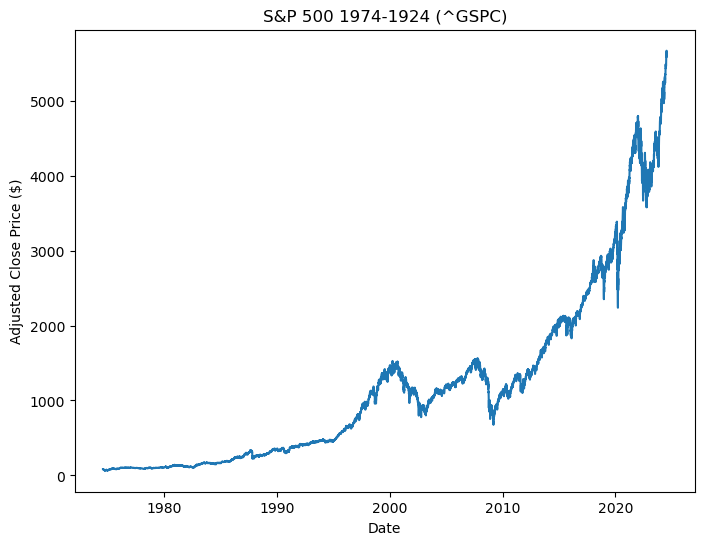

In [17]:
# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(sp500_history['Date'], sp500_history['Adj Close**'])
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.title('S&P 500 1974-1924 (^GSPC)')
plt.show()

## II. Identify Trend 
Here we want to identify the overall market trend in the form
of a simple, closed-form analytical equation. 
We considered low order polynomial, exponential and logarithmic functions.
We assessed each based on fit and complexity using the Bayesian Information Criteria (BIC) and 
adjusted r-squared value built into the statsmodel library.

We found that polynomials improved both the BIC and 
the adj r-squared value up to order four.
We expect worsening results due to numerical instability at order 5 and higher.
The fourth order polynomial captured about 97% of variability.  
Interestingly the exponential polynomial did nearly as well, 
at 95% of variability, with fewer than half the parameters.
The calculated ic value for the exponential is not comparable 
due to the transformation of y prior to analysis.

For this work, we will consider the 4<sup>th</sup> order polynomial due to improved fit.
Since the BIC for order four is lower than that of order one, 
we do not believe the additional parameters added model complexity, 
primarily because there is so much data compared to parameters for these simple functions.
In addition, fits were used is for interpolation 
and to remove any drift for trend that occurs over long time periods
and not for extrapolation, prediction or insight of mechanism of drift.
However, future work may wish to consider the more simplistic exponential fit
or a more complex piece-wise function that may capture qualitatively different trendover periods.
Importantly, the latter may provide insight into fundamental changes related to the market.
For example, qualitative assessment of our results strongly suggested a fundamental
change in market behaviour around 1999. 
Interestingly, this is the year that the Glass-Steagall act was repealed
and retail banks could opperate as investment banks,
which lead to massive increases in trade volume.


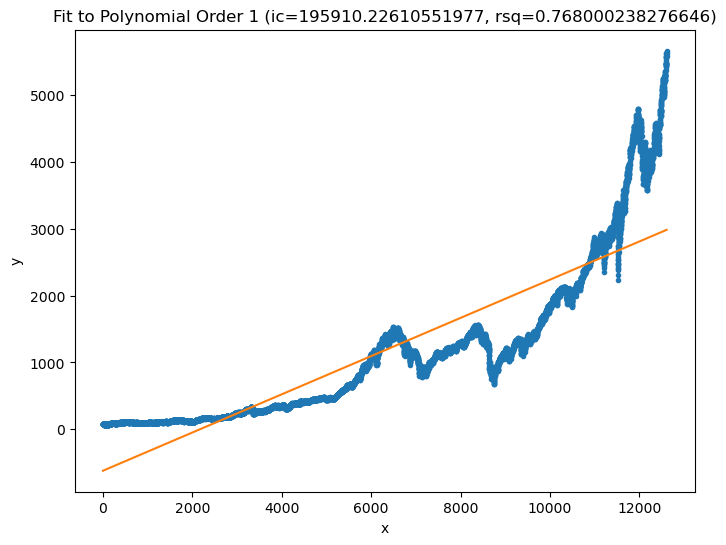

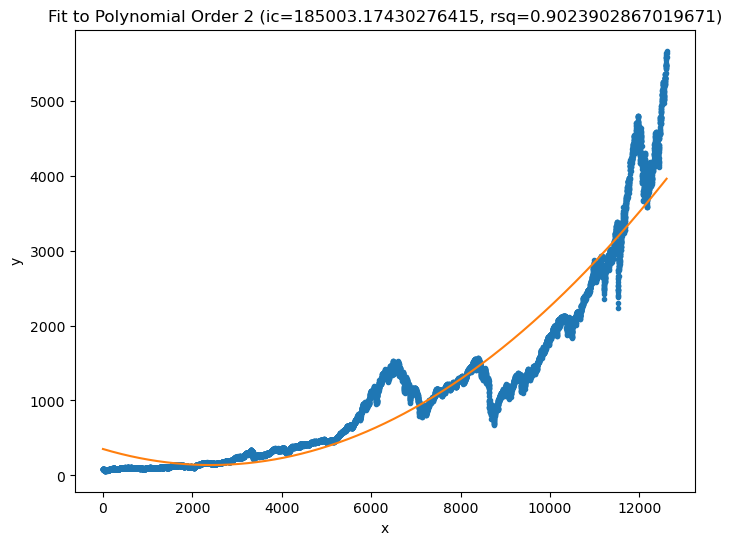

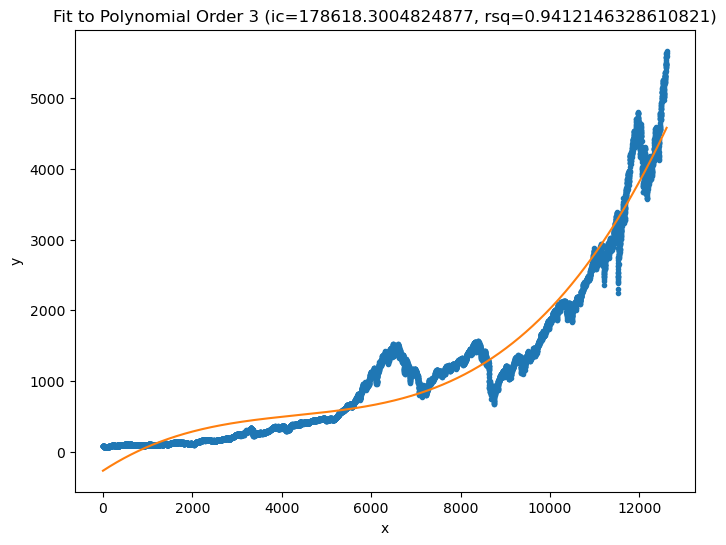

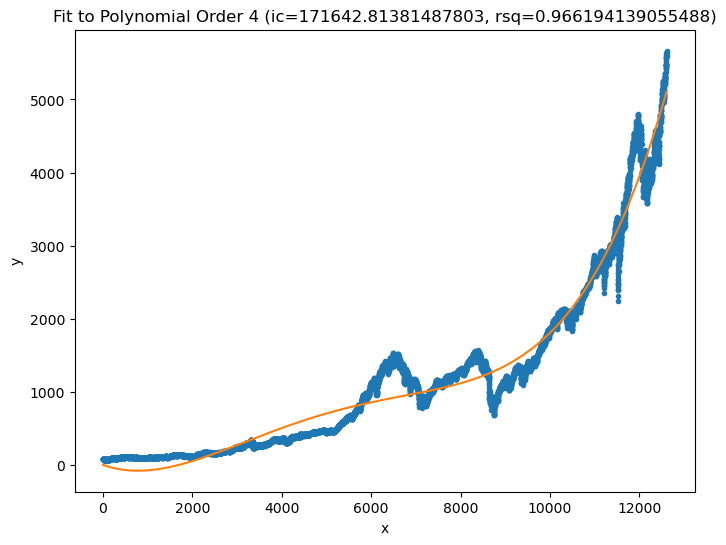

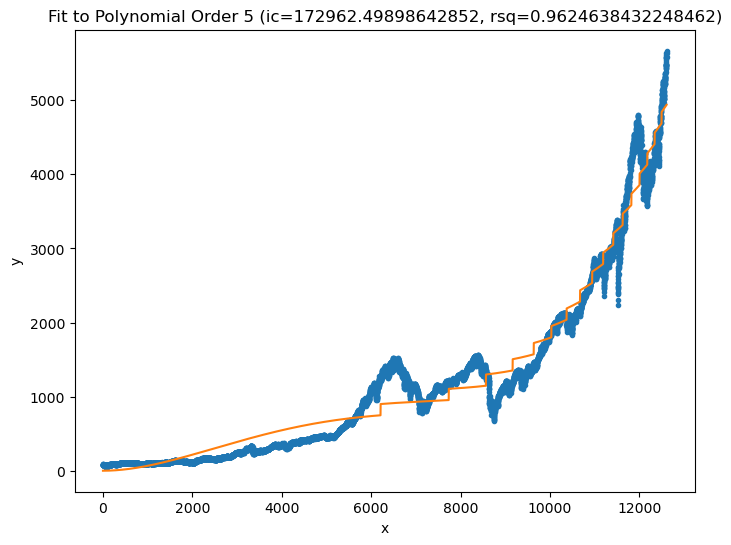

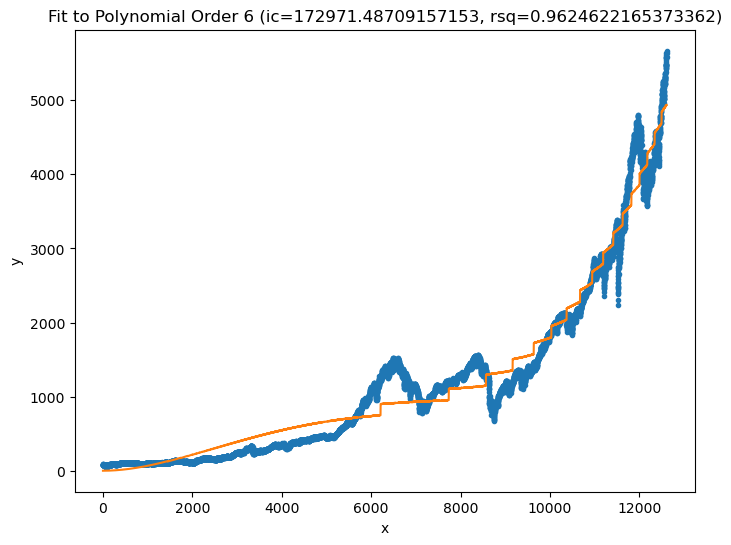

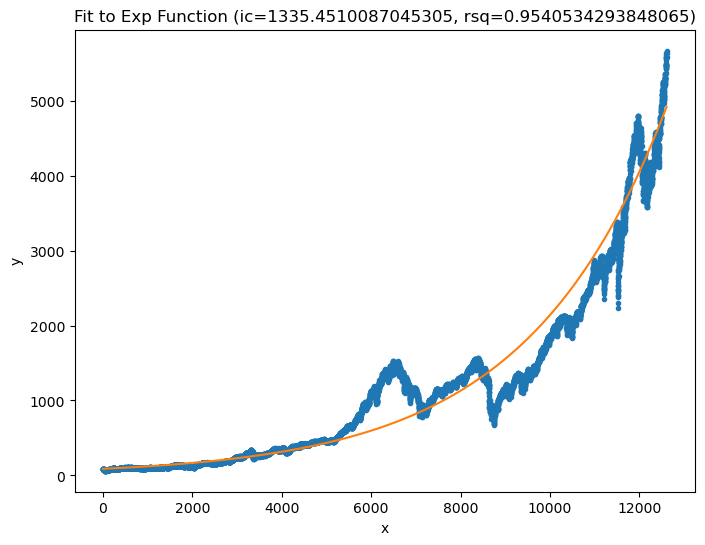

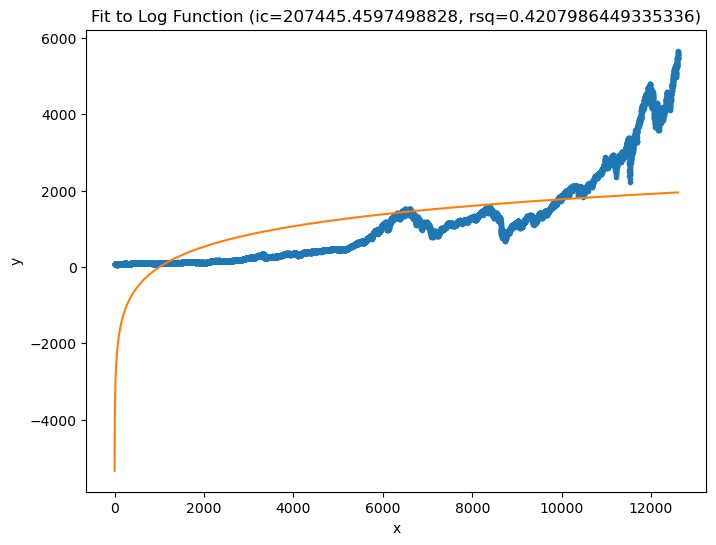

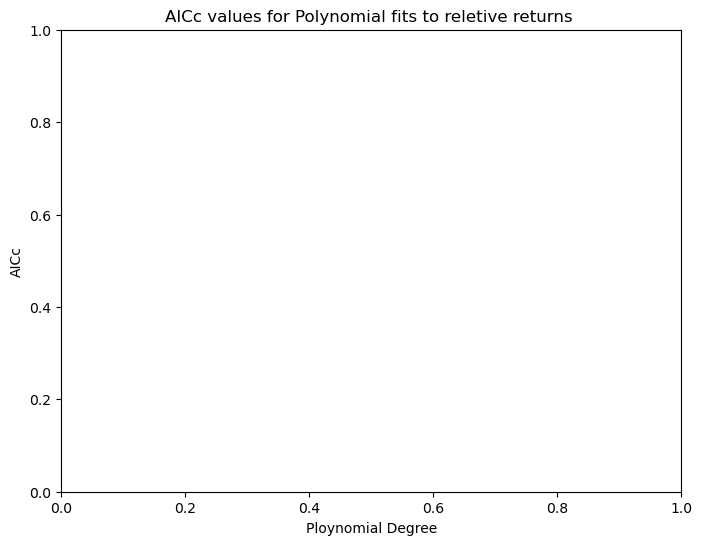

[195910.22610551977, 185003.17430276415, 178618.3004824877, 171642.81381487803, 172962.49898642852, 172971.48709157153, 1335.4510087045305, 207445.4597498828]


In [18]:

# maximum order of polynomials (we exclude 0th) *USER SET*
maxPolyOrder = 6

##############

names = []
minIc = 1000
minIcIndex = -1
ics = []
rsqs = []

x = np.arange(len(sp500_history['Adj Close**']))
y = sp500_history['Adj Close**']



def run_model(X,y):
    # statsmodels ordinary least squares regression model
    regr = OLS(y, X).fit()
    ic = regr.bic
    rsq = regr.rsquared_adj
    yHat = regr.predict(X)
    
    return ic, rsq, yHat, regr

# Run through all poly deg models
for i in range(maxPolyOrder):
    polyOrder = i+1
    name = 'Polynomial Order '+str(polyOrder)
    names.append(name)

    # Create X matrix
    if polyOrder == 1:
        X = add_constant(x.reshape(-1, 1))
    else:
        X = np.c_[X, x**polyOrder]

    ic, rsq, yHat, model = run_model(X,y)

    # Hack to capture the chosen fit of order 4, added posthock
    if polyOrder == 4:
        yHat_final = yHat
    
    ics.append(ic)
    rsqs.append(rsq)
    
    # Plot the data for sanity check
    plt.figure(figsize=(8, 6))
    plt.plot(x, y,'.',x,yHat,'-')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Fit to '+name+' (ic='+str(ic)+', rsq='+str(rsq)+')')
    plt.show()


# Run for exp function: y=Aexp(Bx) -> log(y)=log(A)+Bx
name = 'Exp Function'
names.append(name)

X = add_constant(x.reshape(-1, 1))
ic, rsq, yHatLog, model = run_model(X,np.log(y))
ics.append(ic)
rsqs.append(rsq)

## Hack to capture the chosen fit of order 4, added posthock
#yHat_final = np.exp(yHatLog)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x, y,'.',x,np.exp(yHatLog),'-')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fit to '+name+' (ic='+str(ic)+', rsq='+str(rsq)+')')
plt.show()

# Run for log function: y=A+Blog(x)
name = 'Log Function'
names.append(name)

X = add_constant(np.log(x+1).reshape(-1, 1))
ic, rsq, yHat, model = run_model(X,y)
ics.append(ic)
rsqs.append(rsq)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x, y,'.',x,yHat,'-')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fit to '+name+' (ic='+str(ic)+', rsq='+str(rsq)+')')
plt.show()

# Plot AICcs for inspection
plt.figure(figsize=(8, 6))
#plt.plot(np.arange(30)+1, ics,'.')
plt.xlabel('Ploynomial Degree')
plt.ylabel('AICc')
plt.title('AICc values for Polynomial fits to reletive returns ')
plt.show()

print(ics)
    

## III. Sampling Frequency of Price
For any statistical analysis, we have to determine how much time will pass
between t<sub>i</sub> and t_<sub>i+1</sub> in our data set.
In our experience this is often arbitrarily determined, 
but here we considered a more formal statistical approach. 
We want to maximize the number of sampling points while minimizing their dependence
since a proper statistical analysis would require statistically independent samples.
To do this, we consider the price to be based on both a 'drift' and a 'noise' term.
The drift was defined here by the trend (Section II).
By subtracting the expected value based on this trend, 
we are left with the noise term.
To ensure the noise term is statistically independent, 
we would like to select a sampling rate that minimizes the statistical dependance
between data points that is driven simply by proximity in time.
In a perfect senario this would be done by considering the elapsed time for the 
Auto-Correlation Function (ACF) to drop and then remain at zero.
Of course in any real-world data there is noise that keeps this from happening.
In complex non-linear systems like the stock market, 
there is also the high possibility that our simple description of 
price as drift + noise is too limited.
In this case, it would be reasonable to find that our 'noise' term
cannot be captured by a simple randome variable over a set distribution
An indicator would be  long term memory effects as observed when the ACF does not approach zero
or deviates from it after a period of time.
We arbitrary chose a cutoff of +/-0.05 around the zero to be considered 'reasonably' near zero.

Interestingly, we in fact found long time correlations in the ACF for the noise portion of this trend.
It took about 1000 days for the ACF to reach near zero and after another 1500 left the zero with 95% confidance
due to long time negative correlations.

A similar result was found when considering the price point itself and 
when using the exponential as the trend for the drift.
We also ran an analogous brute force calculation,
as opposed to the the built in statsmodel library ACF method, to confirm the findings.
Our hope was that that the function would remove any systemic behaviour.
That did not happen in this case.
There are statistical methods to investigate further, and more rigorously;
however, they are beyond the scope of this project.
In the next section, we will reapply the analysis to the return.



[1.         0.9963323  0.99318941 ... 0.07133199 0.07124161 0.0711642 ]


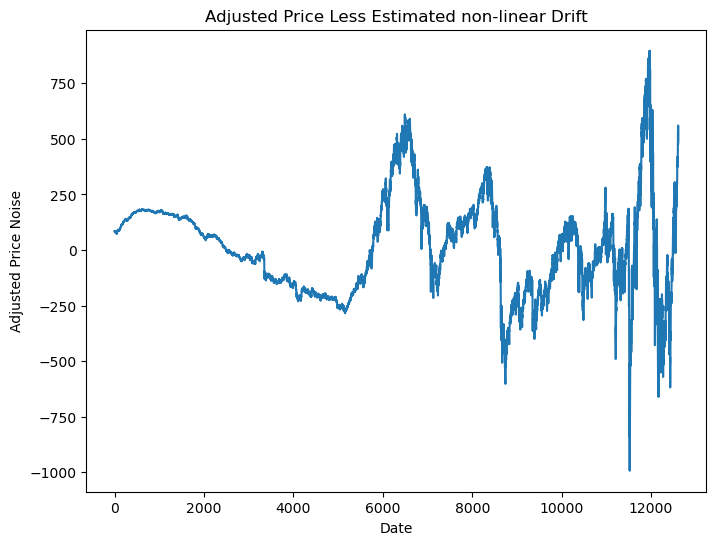

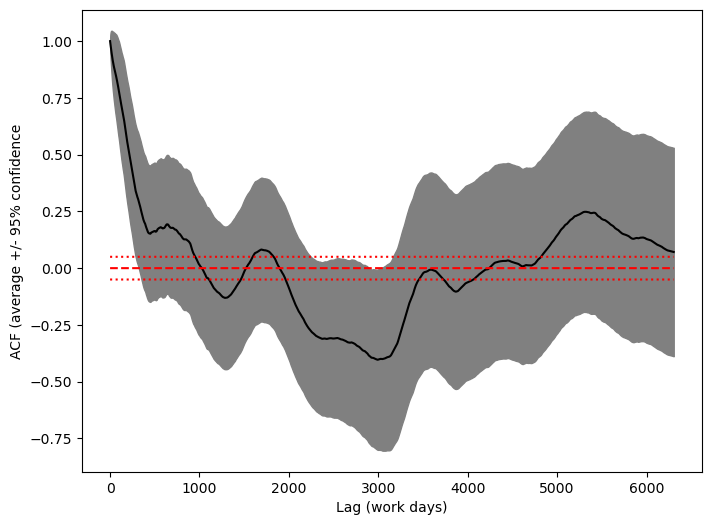

In [38]:
# setting ACF zero cutoffs at +/- 0.5
acfCutoff = 0.05

# Define the autocorr funciton
def acf(x,fracLag = 0.5):
    # Get auto corelation function for noise (with 68% confidence interval)
    n = len(x)
    # maximum lag considered is % of total 
    maxLag = int(fracLag*n)

    # Well accepted method
    acf, acfConf = stattools.acf(x,alpha=(1-0.95),nlags=maxLag)

#    # Rubber meets the road, brute force method to double check (long run time)
#    x = x - np.mean(x)
#    acf = np.zeros(maxLag)
#    acfConf = np.zeros((maxLag,2))
#    for delta in range(maxLag):
#        corr = np.array([])
#        for i in range(n):
#            indLag = i+delta
#            if indLag < n: 
#                corr = np.append(corr,x[i]*x[i+delta])
#        acf[delta] = np.mean(corr)
#        acfConf[delta,0] = acf[delta] + np.sqrt(np.var(corr)/len(corr))
#        acfConf[delta,1] = acf[delta] - np.sqrt(np.var(corr)/len(corr))
       

    return acf, acfConf
    
    
# Remove the drift 
# Recall that we previously dfined y as our target, adjusted closing price
# We also defined yHat_final as our prefered fit

yNoise = y-yHat_final

yNoise_ac, yNoise_acConf = acf(yNoise)
print(yNoise_ac)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x, yNoise)
plt.xlabel('Date')
plt.ylabel('Adjusted Price Noise')
plt.title('Adjusted Price Less Estimated non-linear Drift')
plt.show()



# Plot the data for sanity check
plt.figure(figsize=(8, 6))
lag = np.arange(len(yNoise_ac))
plt.plot(lag, yNoise_ac,color='black')
plt.fill_between(lag, yNoise_acConf[:,0],yNoise_acConf[:,1],color='gray')
plt.plot(lag, yNoise_ac*0 ,'r--') 
plt.plot(lag, yNoise_ac*0 + acfCutoff,'r:') 
plt.plot(lag, yNoise_ac*0 - acfCutoff,'r:') 


plt.xlabel('Lag (work days)')
plt.ylabel('ACF (average +/- 95% confidence')
#plt.title('')
plt.show()


## IV. Sampling Frequency of Returns
Given the result above, we considered the sampling rate relavant to returns, not price.
We believe this is still a relavant feature to consider for determining the 
meta parameter of sampling rate as it relates to relavant statistical independence.
This is because the methods employed estimate metrics involving the return itself.
Here, we specifically used relative returns, (x<sub>end</sub>-x<sub>start</sub>)/x<sub>end</sub>,
of the adjusted closing price.

### i. Transform to Returns
Our final statistical analysis will be based on monthly returns. 
To simplify this we defined months time t to t+30 days as opposed to calendar months. 
Since stock is traded when the market is open, our time series only contains weekdays.
We therefore removed approximately 2 weekends days per week from our 30 day month. 
Given 4.25 weeks each month, we have 8.5 weekend days. 
We then rounded up to account for a handful of holidays.
That left us with 21 consecutive time points per month.



[-0.09680115 -0.10737371 -0.10571531 ...  0.03877307  0.04296488
  0.02884417]
[ -8.11  -8.97  -8.86 ... 210.19 233.46 156.67]
[   21    22    23 ... 12605 12606 12607]


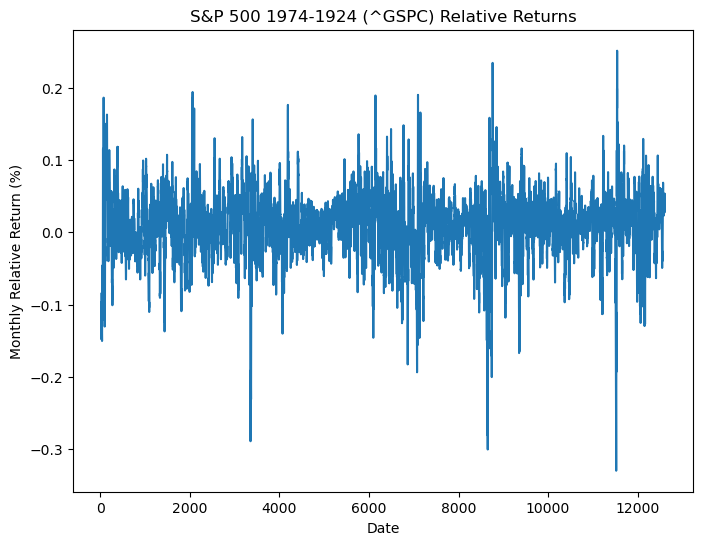

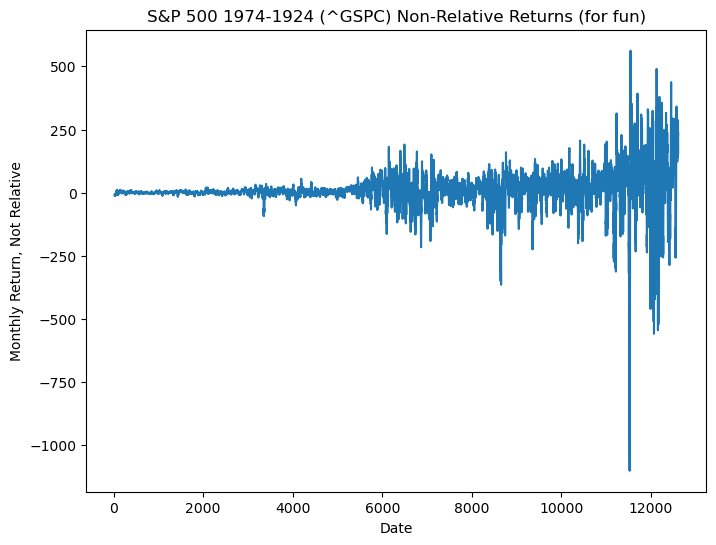

In [27]:
# Just to be sure we know whats what 
x = np.arange(len(sp500_history['Adj Close**']))
y = np.array(sp500_history['Adj Close**'])


# Open market Days in Month (dinm)
dinm = 30 - 9

# calculate returns
def calcReturns(y, period=21, relative=True):
    n = len(y)
    yReturn = np.zeros(n-period)
    xReturn = []
    for i in range(n-period):
        
        if relative:
            denom = y[i]
        else: 
            denom = 1.0
            
        yReturn[i] = (y[i+period] - y[i]) / denom
        xReturn.append(x[i+period])
        
    xReturn = np.array(xReturn)
    return xReturn, yReturn


xReturn, yReturn = calcReturns(y, period=dinm)
xReturn, yReturn_nonrel = calcReturns(y, period=dinm, relative=False)#just for a fun note

# Show for sanity check
print(yReturn)
print(yReturn_nonrel)
print(xReturn)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(xReturn, yReturn)
plt.xlabel('Date')
plt.ylabel('Monthly Relative Return (%)')
plt.title('S&P 500 1974-1924 (^GSPC) Relative Returns')
plt.show()

# Plot the non relative data for fun
plt.figure(figsize=(8, 6))
plt.plot(xReturn, yReturn_nonrel)
plt.xlabel('Date')
plt.ylabel('Monthly Return, Not Relative')
plt.title('S&P 500 1974-1924 (^GSPC) Non-Relative Returns (for fun)')
plt.show()

### ii. Autocorrelation Function
As in Section III, we caculated the ACF to determine the time needed 
for samples to be considered reasonably statistically independent.
However, In this case, we used the returns as determined above in Section IV.i. 
as opposed to the price or the deviation in price from a trend.

In all cases we observed the ACF to vershoot the zero and go into negative correlation
as determined by values very slightly lower than the lower bound of our cutoff (i.e acf < -0.05).
This is typical in many non-linear dynamic systems
as apposed to a smooth approach towards zero.

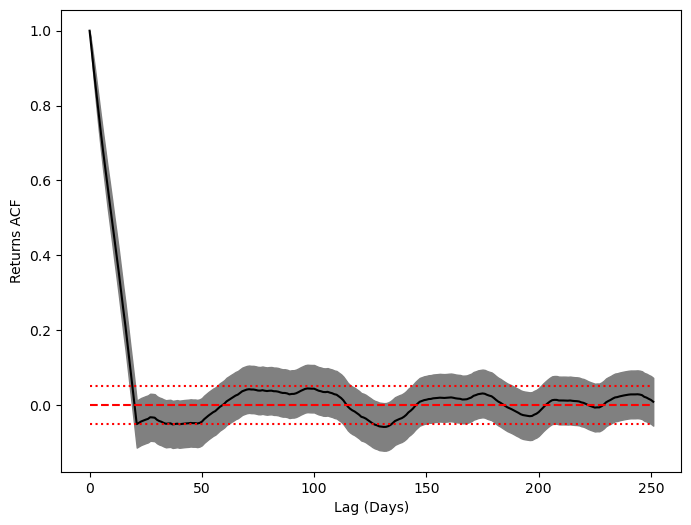

Return ACF
[ 1.          0.94265949  0.88781693  0.83450437  0.78118483  0.72907342
  0.67881937  0.63131204  0.58293245  0.5385275   0.49289241  0.44587297
  0.40088502  0.35441212  0.30497151  0.25559961  0.20914923  0.15732293
  0.10462866  0.05399521  0.00221882 -0.05145883 -0.04773628 -0.04430351
 -0.04192801 -0.03950767 -0.03749805 -0.03313351 -0.0335628  -0.03438202
 -0.03982951 -0.04316466 -0.0452306  -0.04827631 -0.05058237 -0.04984563
 -0.0494406  -0.05221098 -0.05136242 -0.05032412 -0.05171612 -0.05098849
 -0.0502021  -0.04964173 -0.0492004  -0.04827928 -0.04885297 -0.04881369
 -0.04981505 -0.04834922 -0.04505121 -0.03852727 -0.03352735 -0.02848975
 -0.02410528 -0.01974985 -0.01654098 -0.01114107 -0.00548615 -0.00153811
  0.00290874  0.00924224  0.01310002  0.01706133  0.02070782  0.0247522
  0.02733158  0.0318476   0.03636104  0.03871843  0.04082878  0.04179351
  0.0410256   0.04101149  0.03987432  0.03826234  0.0379938   0.03919753
  0.03777107  0.03691016  0.03768095  0.0

In [40]:
# Recall the autocorr funciton is alreaded defined, acf()
# Recall the return is already calculated, yReturn, xReturn

# Calc autocorr
yReturn_ac, yReturn_acConf = acf(yReturn,fracLag=0.02)
lag = np.arange(len(yReturn_ac))


# Plot the data for sanity check
plt.figure(figsize=(8, 6))
lag = np.arange(len(yReturn_ac))
plt.plot(lag, yReturn_ac,color='black')
plt.plot(lag, lag*0 ,'r--') 
plt.plot(lag, lag*0 + acfCutoff,'r:') 
plt.plot(lag, lag*0 - acfCutoff,'r:') 
plt.fill_between(lag,yReturn_acConf[:,0],yReturn_acConf[:,1],color='gray')
plt.xlabel('Lag (Days)')
plt.ylabel('Returns ACF')
#plt.title('')
plt.show()
print('Return ACF')
print(yReturn_ac[:150])
print('Return ACF 95% Conf')
print(yReturn_acConf[:150])


### iii Selecting a Sampling Frequency

Here we formulated a set of rules to systematically select a sampling frequency from the ACF.
While the zero does remain in the 95% CI for all lag after the initial zero between 21 and 22 days,
this does not mean we have a 95% confidence that it is zero.
If the 95% CI did *not* contain zero at some point, 
we might make the claim that the correlation is *not* zero at that point with 95% confidence.
Consider choosing a CI of 100%. The error bounds would be +/-inf, 
and all lag values would contain zero.
Clearly this does not mean that all lags for any function have a 100% confidence of being zero.
Alternatively, a CI of 0 would be bounds of +/- 0, only discrete points 
where the AC crosses the x-axis would the value contain zero.

In this case, we chose to require that the zero is within the 95% CI.
This is a necessary but not a sufficient condition for being near zero.
We also chose to require the ACF value to be within the cutoff range, 
defined above as +/- 0.05.
We also went further to require the above to be true for one month, 
defined above as 21 days (i.e. 21 consecutive data points in the time course).
Since the returns are 21 days, it stands to reason we would like our samples to be spaced
such that they are nearly uncorrelated over 21 days.

We found that the above criterion was met at 43 days of lag.
It is at this time that for one month the acf is within our near zero cutoff and
it is not significantly different than zero.
The remainder of analysis will mainly focus on data with a 
43 day sampling frequency of relative monthly returns. 


Samp Freq
- 43


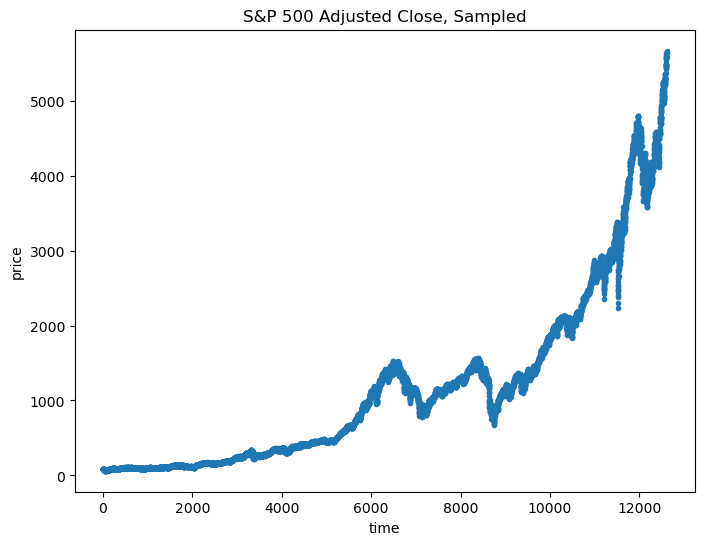

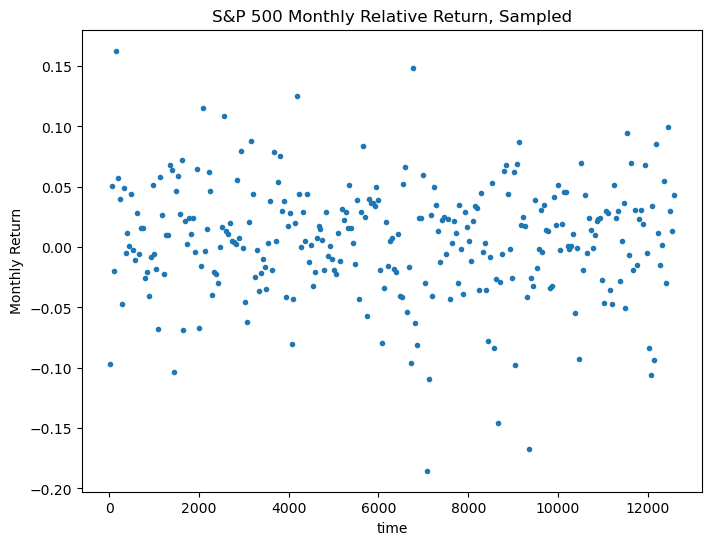

In [45]:



delta_return = dinm
delta_sf = 100000

for i in range(len(yReturn_ac-dinm)):
    uncorr = True

    for j in range(dinm):
        # check if the mean is in bounds
        if np.abs(yReturn_ac[i+j]) > acfCutoff: 
            uncorr = False
            break
            # check if the CI bounds contain zero
            if yReturn_acConf[i+j,0] * yReturn_acConf[i+j,1] > 0:
                uncorr = False
                break
    if uncorr:
        delta_sf = lag[i]
        break

print('Samp Freq')
print('- '+str(delta_sf))

n = len(sp500_history['Adj Close**'])
inds = np.arange(0,n,delta_sf)

x = np.arange(len(sp500_history['Adj Close**']))
y = np.array(sp500_history['Adj Close**'])
x_samp = x[inds]
y_samp = y[inds]
# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x,y,'.')
plt.xlabel('time')
plt.ylabel('price')
plt.title('S&P 500 Adjusted Close, Sampled')
plt.show()

# *** depending on returns from above section ***
n = len(xReturn)
inds = np.arange(0,n,delta_sf)
xReturn_samp = xReturn[inds]
yReturn_samp = yReturn[inds]
# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(xReturn_samp,yReturn_samp,'.')
plt.xlabel('time')
plt.ylabel('Monthly Return')
plt.title('S&P 500 Monthly Relative Return, Sampled')
plt.show()

## V. Identify Pricing Deviations
Given the sampiling frequency determined above, in Section IV.iii,
we will revisit the pricing data in order to 
recalculate systemic drift and pricing deviations (previously reffered to as noise). 

### i. Re-Assessing Trends for Systemic Drift 
Here we used the same basic code as in Section II, 
but we apply it to the properly sampled data to confirm.
We again found the 4th order polynomial to be the best fit.

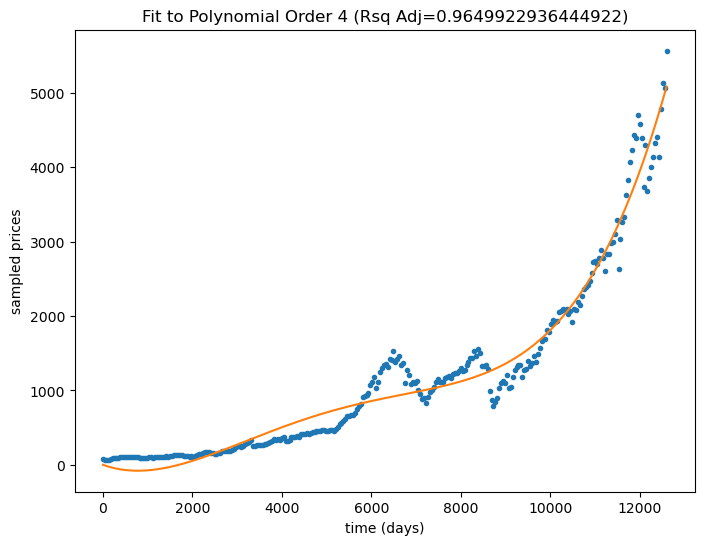

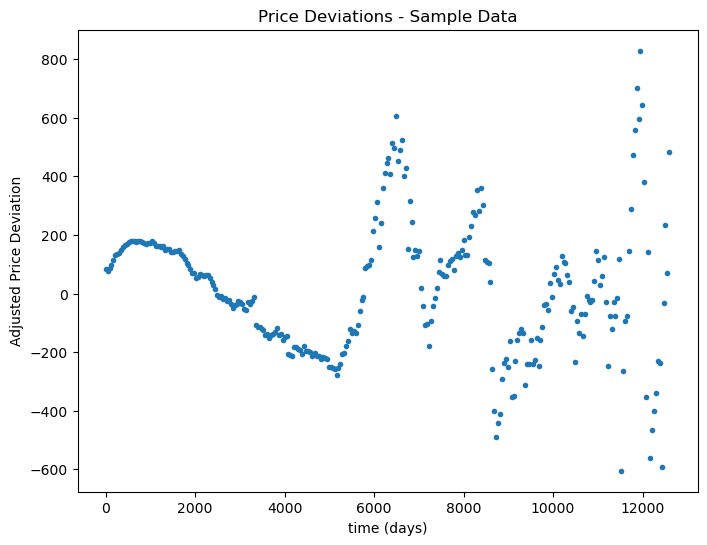

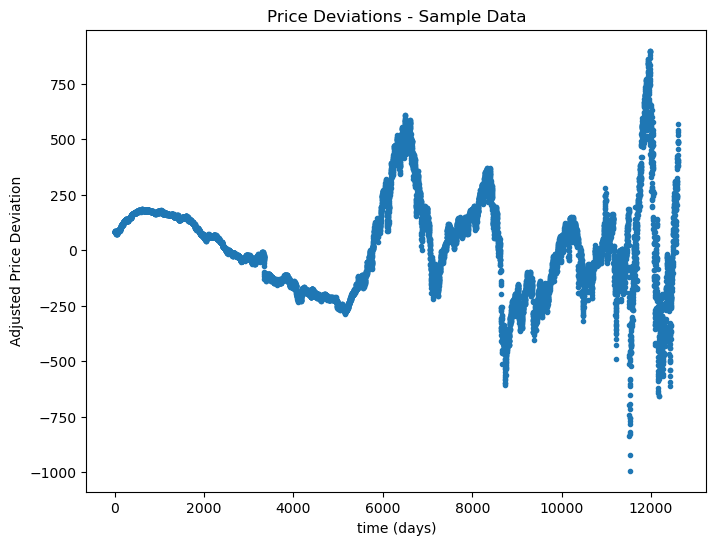

In [46]:

 
# maximum order of polynomials (we exclude 0th) *USER SET*
maxPolyOrder = 6

def run_model(X,y):
    # statsmodels ordinary least squares regression model
    regr = OLS(y, X).fit()
    ic = regr.bic
    rsq = regr.rsquared_adj
    yHat = regr.predict(X)
    
    return ic, rsq, yHat, regr

# given repeted use we are going to define a function for this

def pickSimpModel(x,y,maxPolyOrder):

    nameBest = ''
    modelBest = ''
    yHatBest = []
    rsqAdjBest = 0 
    # we decided to use adjusted r squared here because the ics
    # calculated in stats ols function are not comparable if a
    # variable transformation is done on y prior to the function
    # call, which is what we do in exp.
    # However, this should not be an issue given the small number 
    # of parameters for these models.
    if len(y) < maxPolyOrder*4: 
        print('Warning: Low obs to order, double check model selection criterion')

    # Run through all poly deg models
    for i in range(maxPolyOrder):
        polyOrder = i+1
        name = 'Polynomial Order '+str(polyOrder)

        # Create X matrix
        if polyOrder == 1:
            X = add_constant(x.reshape(-1, 1))
        else:
            X = np.c_[X, x**polyOrder]

        ic, rsqAdj, yHat, model = run_model(X,y)
        
        if rsqAdj > rsqAdjBest:
            rsqAdjBest = rsqAdj
            nameBest = name
            modelBest = model
            yHatBest = yHat
        
    


    ### Run for exp function: y=Aexp(Bx) -> log(y)=log(A)+Bx
    name = 'Exp Function'

    X = add_constant(x_samp.reshape(-1, 1))
    ic, rsqAdj, yHatLog, model = run_model(X,np.log(y))
    
    if rsqAdj > rsqAdjBest:
        rsqAdjBest = rsqAdj
        nameBest = name
        modelBest = model
        yHatBest = np.exp(yHatLog)


    ### Run for log function: y=A+Blog(x)
    name = 'Log Function'

    X = add_constant(np.log(x_samp+1).reshape(-1, 1))
    ic, rsqAdj, yHat, model = run_model(X,y)

    if rsqAdj > rsqAdjBest:
        rsqAdjBest = rsqAdj
        nameBest = name
        modelBest = model
        yHatBest = yHat


    return rsqAdjBest, nameBest, modelBest, yHatBest



rsqAdjBest, nameBest, modelBest, yHatBest = pickSimpModel(x_samp,y_samp,maxPolyOrder)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x_samp, y_samp,'.',x_samp,yHatBest,'-')
plt.xlabel('time (days)')
plt.ylabel('sampled prices')
plt.title('Fit to '+nameBest+' (Rsq Adj='+str(rsqAdjBest)+')')
plt.show()

################

yNoise = y_samp-yHatBest

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x_samp, yNoise, '.')
plt.xlabel('time (days)')
plt.ylabel('Adjusted Price Deviation')
plt.title('Price Deviations - Sample Data')
plt.show()

x = np.arange(len(sp500_history['Adj Close**']))
y = sp500_history['Adj Close**']


## Deviations in full data set
# just in-case we want to look at it but
# using the model built on properly spaced sample data

# recall that we did some manipulation before calling the model
# now we need to do it again
# in the future we should write in a function to solve for this issue
# to avoid human error
for i in range(4):
        polyOrder = i+1
        # Create X matrix
        if polyOrder == 1:
            X = add_constant(x.reshape(-1, 1))
        else:
            X = np.c_[X, x**polyOrder]

yNoise_full = y-modelBest.predict(X)

# Plot the data for sanity check
plt.figure(figsize=(8, 6))
plt.plot(x, yNoise_full, '.')
plt.xlabel('time (days)')
plt.ylabel('Adjusted Price Deviation')
plt.title('Price Deviations - Sample Data')
plt.show()
    

### ii. Use Robust Statistics to Define Deviations
Using median and absolute deviation as a robust analogue to 
the sample mean and standard deviation,
which are commonly used for expected return and volatility metrics. 
Here we are defining 1, 2 and 3 abs devs as abnormal, semi-rare and rare events.

In [47]:
#  CDefine the Thresholds *USER SET*
def thresh(x):
    frac_ab = 0.68 # abnormal event - equivlant to 1 stdev 
    frac_sr = 0.95 # semi-rare event - equivlant to 2 stdev
    frac_r = 0.995 # rare event
    n = len(x)
    x_sorted = np.sort(x)

    thresh_ab = x_sorted[int(n*frac_ab)]
    thresh_sr = x_sorted[int(n*frac_sr)]
    thresh_r = x_sorted[int(n*frac_r)]
    return thresh_ab, thresh_sr, thresh_r

# We are working with robust stats so shift to the median 
yNoise = yNoise - np.median(yNoise)

# for deviations, we dont care if they are positive or negative
yDev = np.abs(yNoise)

# Caclulat threshold values
thresh_ab, thresh_sr, thresh_r = thresh(yDev)

# Print for sanity check
n = len(yDev)
print(n)
print(str(thresh_ab)+' - '+str(int(n-.68*n)))
print(str(thresh_sr)+' - '+str(int(n-.95*n)))
print(str(thresh_r)+' - '+str(int(n-.995*n)))


294
187.87363022135744 - 94
476.77914642058386 - 14
696.3651702512248 - 1


## VI. Event and Lengths
Here, we are concerned with events that are less frequent.
When an deviation is identified as deviation >= event threshold 
it is marked as an event and is considered to continue, 
proceeding over all consecutive time points, 
until it drops below the event threshold.
This determines the overall events length.

We found 16 abnormal events 
(defined as 33% of most extreme price deviations from an expected trend)
with a median of 129 open market days (just over six months).
This streches from about two months to over three and a half years.
The length of semi-rare and rare deveiation events reduces drastically
before trending back to expected values.
Based on these numbers it would be unwise to for investors 
to wait at least six months before any major changes 
(beyond rebalancing) on ones portfolio even in the face 
of sudden, seemingly unexpected, market change.



Threshold: 187.87363022135744
Number of Events: 18
Median Event Length: 129.0
Event Lengths:
[ 43  43  43  43  86  86  86 129 129 129 301 301 344 387 387 602 903]
Total Time:
4042


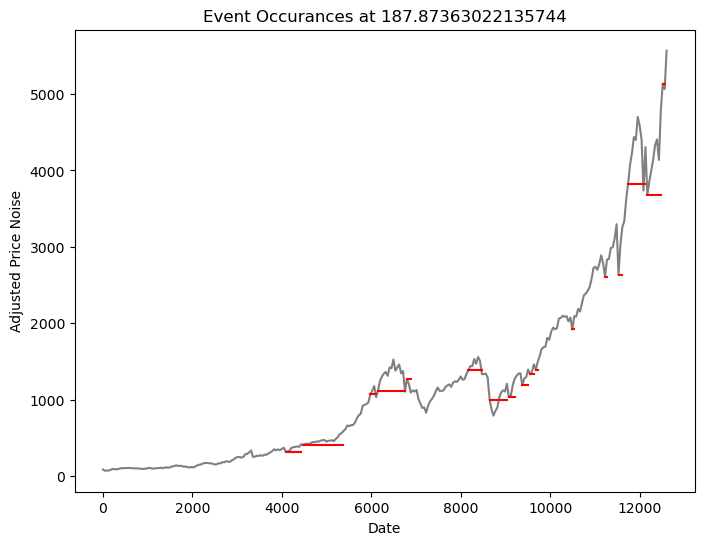

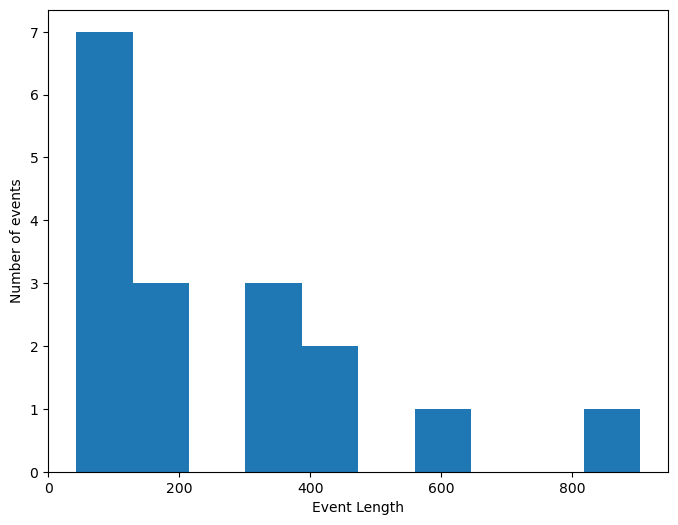

Threshold: 476.77914642058386
Number of Events: 8
Median Event Length: 43.0
Event Lengths:
[ 43  43  43  43  86 129 215]
Total Time:
602


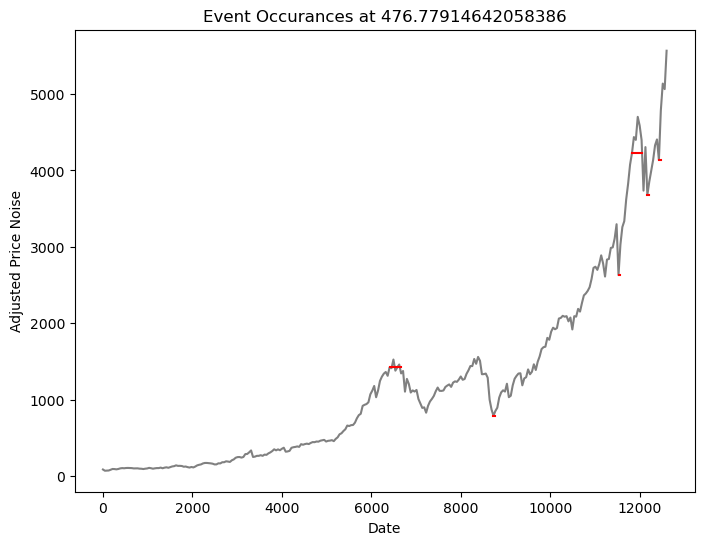

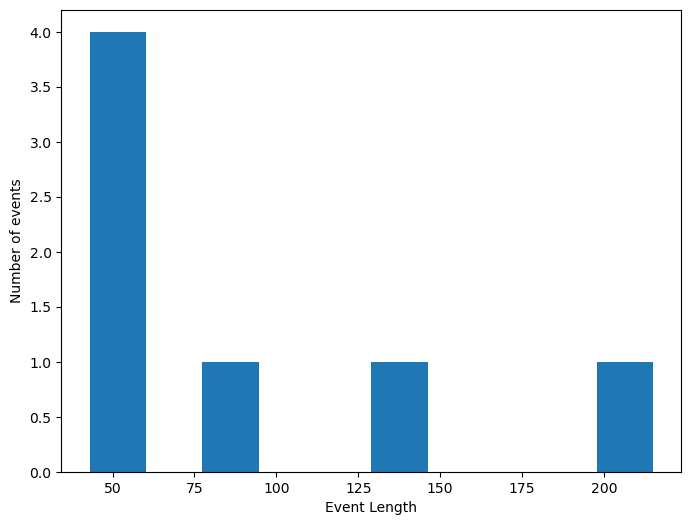

Threshold: 696.3651702512248
Number of Events: 2
Median Event Length: 43.0
Event Lengths:
[43 43]
Total Time:
86


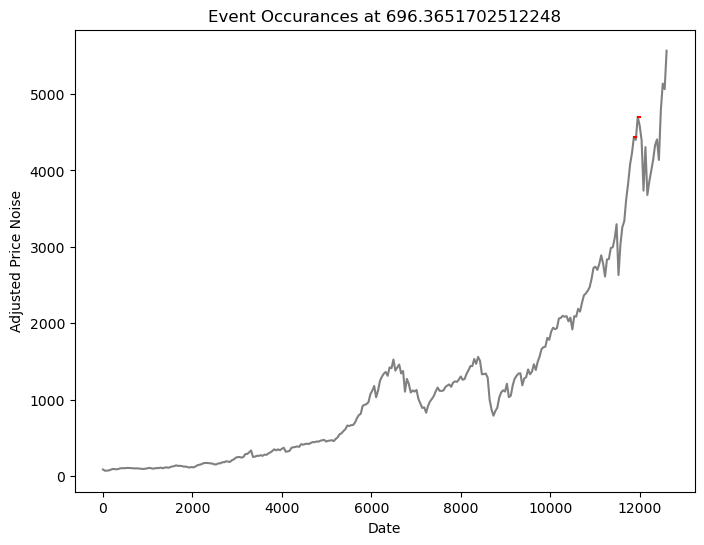

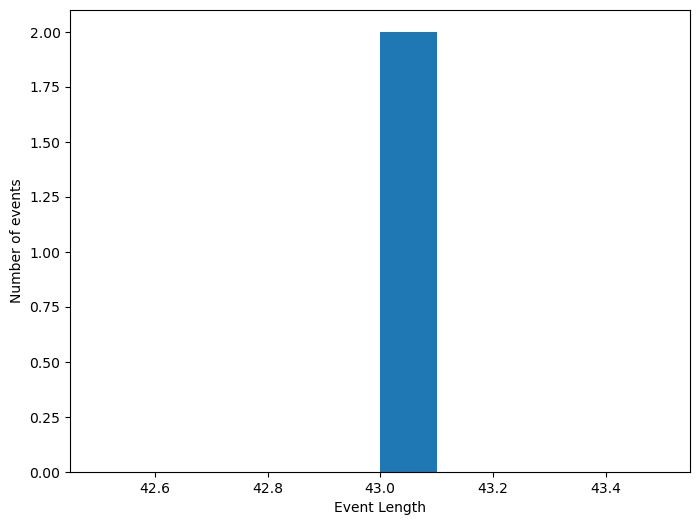

In [48]:
# Define event finder

def flagEvents(time,value,thresh):
    n = len(time)
    event_time=[]
    event_ind=[]
    event_length=[]
    started=False 
    for i in range(n):
        if (value[i]>=thresh) and (started==False):
            started=True
            event_time.append(time[i])
            event_ind.append(i)

            start_time=time[i]
        elif (value[i]<thresh) and (started==True):
            started=False
            end_time=time[i]
            event_length.append(end_time-start_time)
            
    return event_time, event_length, event_ind

for thresh in [thresh_ab, thresh_sr, thresh_r]:
    event_time, event_length, event_ind= flagEvents(x_samp,yDev,thresh)
    
    print('Threshold: '+str(thresh))
    print('Number of Events: '+str(len(event_time)))
    print('Median Event Length: '+str(np.median(event_length)))
    print('Event Lengths:')
    print(np.sort(event_length))
    print('Total Time:')
    print(np.sum(event_length))
    inds = np.array(event_ind)
    # Plot the data for sanity check
    plt.figure(figsize=(8, 6))
    #plt.plot(x_samp, y_samp,'_',x_samp[inds],y_samp[inds], '.')
    plt.plot(x_samp, y_samp,color='gray')
    for i in range(len(inds)):
        ind = inds[i]
        event_x0 = x_samp[ind]
        if i == len(event_length): # if last event has not finished, it wont have a length yet
            event_xt = x_samp[-1] # we are setting these events to end at the time frame end
        else:
            event_xt = event_x0 + event_length[i]
        event_y = y_samp[ind]
        plt.plot([event_x0,event_xt],[event_y,event_y],color='red')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Price Noise')
    plt.title('Event Occurances at ' + str(thresh))
    plt.show()
    plt.figure(figsize=(8, 6))

    plt.hist(event_length)
    plt.xlabel('Event Length')
    plt.ylabel('Number of events')
    plt.title('')
    plt.show()



# *** Consider doing the full time course, will need to re assess the yHats, which means we needed to save the modle from before




## VII. Portfolio Holding Time
A simple analysis was done regarding the average portfolio return 
depending on portfolio hold time.
We suggest that the longer a portfolio is held, the high the return.
We looked at relative returns in one month increments from zero to over 15 years.
Averages were taken over the full 50 year S&P time course used above.
There was a clear linear dependance with a slope of about 0.17 or 17% increase per year.
The 95% confidence interval does suggest wide variation depending on the exact timing 
of when a portfolio is started or stopped.
It is possible for a few instances a portfolio can lose money even after 10 year,
but there many more instances of portfolios increasing above 200%.
Although stats become worse from longer time periods, it was suggestive
that portfolios nearly always increase in value after 13 years - some as high as 400%.
Our suggestion is that basic portfolio managment is a good to great strategy for a hold period of 10 to 13+years.

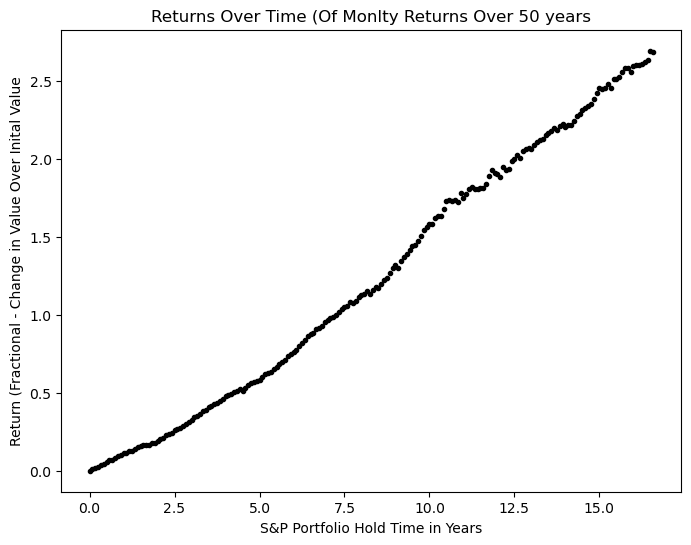

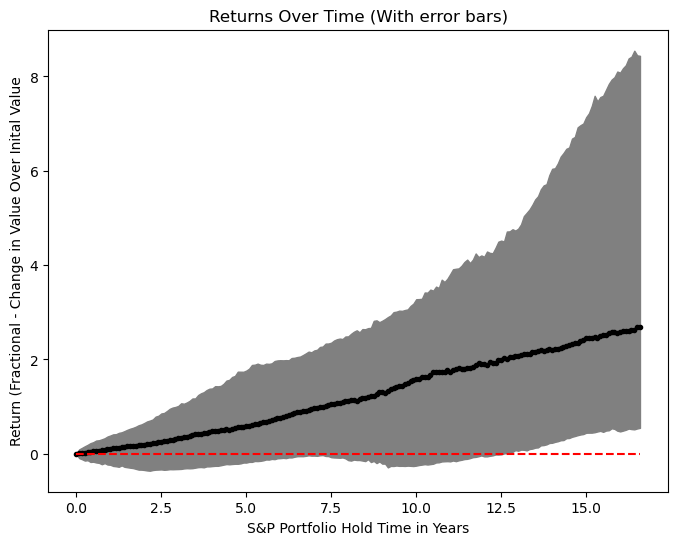

In [49]:
def returnFunc(a,b):
    return (b-a)/a
    
def calcRunningReturns(x):
    
    n = len(x)
    returns = np.array([])
    confup = np.array([])
    confdn = np.array([])
    lags = np.array([])
    
    for lag in range(int(n/3)):
        
        temp = []
        for j in range(0,n-lag,1):
            temp.append(returnFunc(x[j],x[j+lag]))
            
        temp = np.sort(temp)
        m = len(temp)
        indUp = int(m/2) + int(m*.475)
        indDn = int(m/2) - int(m*.475)

        returns = np.append(returns,np.median(temp))
        confup = np.append(confup,temp[indUp])
        confdn = np.append(confdn,temp[indDn])
        lags = np.append(lags,lag)
        
    return returns, np.c_[confup,confdn], lags

y = sp500_history['Adj Close**'].to_numpy()
# monthly
inds = np.array(range(0,len(y),21))


returns, conf, lags = calcRunningReturns(y[inds])



plt.figure(figsize=(8, 6))
plt.plot(lags/12,returns,'.',color='black')
#plt.fill_between(lags/12,stDev*2+returns,returns-stDev*2,color='gray')
plt.xlabel('S&P Portfolio Hold Time in Years')
plt.ylabel('Return (Fractional - Change in Value Over Inital Value')
plt.title('Returns Over Time (Of Monlty Returns Over 50 years')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(lags/12,returns,'.',color='black')
plt.plot(lags/12,returns*0,'--',color='red')
plt.fill_between(lags/12,conf[:,0],conf[:,1],color='gray')
plt.xlabel('S&P Portfolio Hold Time in Years')
plt.ylabel('Return (Fractional - Change in Value Over Inital Value')
plt.title('Returns Over Time (With error bars)')
plt.show()

## VIII. Determining Sampiling Period
The mean-value analysis of Modern Portfolio Theory relies on 
statistical estimates of a return and risk parameter.
As shown above, we have considered median realitive return and its median absolute deviation.
To calculate these, we need a proper sampiling frequency (determined in Section IV.iii)
and a sampiling period (number of consecutive months to analyze over).

Previous analysies have shown that short sampiling periods lead to 
low-biased estimates of risk, as expected with small sample sizes.
However, long sampling periods (10, 20, 50 years) may not be avalible,
require additional copute resources and may not hold information relavant 
to the current market.

The question is, how long is long enough.
We caclulated the risk parameter over different period 
lengths in the S&P 500 from 3 to 200 months.
As expected the value start relativly low but quickly becomes 
relativly stable, at higher risk estimates, over longer sampiling periods.

We also caclulated the estimated return parameter and compared it 
to the 'acutaul' return at 1, 6 and 12 months following the sampiling period.
From this the absolute deviation was taken, which is comparable to our 
estimated or 'predicted' risk parameter. 
In estimating all parameters, we appilied a temporal cross-validaition study 
that allows us to average (or in this case take the meadian) over a moving time 
window, which provides increased statistical power, particularly for shorter sampiling periods.

We found, at least in the case of the S&P 500,
our deviation between predictive and actual returns to 
generally decrease with increasing sampiling period  
up to the full 200 months.
We note that it is not perfectly monotonic, 
which may be due to statistical noise or 
low, but seemingly relavant, long-term memory ocilations in the market
as described above and else where.
We also noted that both prdicted and actual deviation show
clear signs of flatening out, or approaching an asymptote.
While it would be favorable if both clearly, stabally approched the 
same asymtotic point, statistical noise and the nature of the 
data made that impossible even for a long lived index like the S&P 500.
It's also likly that there are diminishing returns to only considering 
very long sample periods in future portfolio analysis including 
the lack of data for many assets and other confounding facotrs 
(known or otherwise) that also contribute to errors.

To this end, we chose to treat the both trajectories 
similar to that of an exponental decay, caclulate 
an approximate asymptotic value and use a decay 
of 90% (arbitrarily chosen) as the cutoff.
We will use the maximum of the two cutoffs 
(predicted vs actual) for the sampiling period moving forward.

However, upon trying this, even with a hack in place, 
we found the decay was not appropriate.
Althought, a model could be formed from a non-linear 
(possibbly logistic) function, we belived this was unnecasarily complicated 
and would be difficult to easily interpret the results.
For our purposes we wanted somthing more straight forward.
We chose to purse a 2-piecewise linear function.
Here the cuttoff for the functions could easily searve as a cuttoff for the needed period.
This would be particularly true if the slopes were drastically different.
We used the mean value with a slight bias towards shorter cutoff periods as the slection criteria.
The maximum of predicted vs actual deviation cutoff was then chosen.





Test for Convergance
- Did Converge
- time = 92.14285714285714
- p = 1.0

Test for Break
- Pred
-- rsq = 0.5399961580091546
-- time = 16.38095238095238
- Act
-- rsq = 0.5703125760583114
-- time = 372.66666666666663


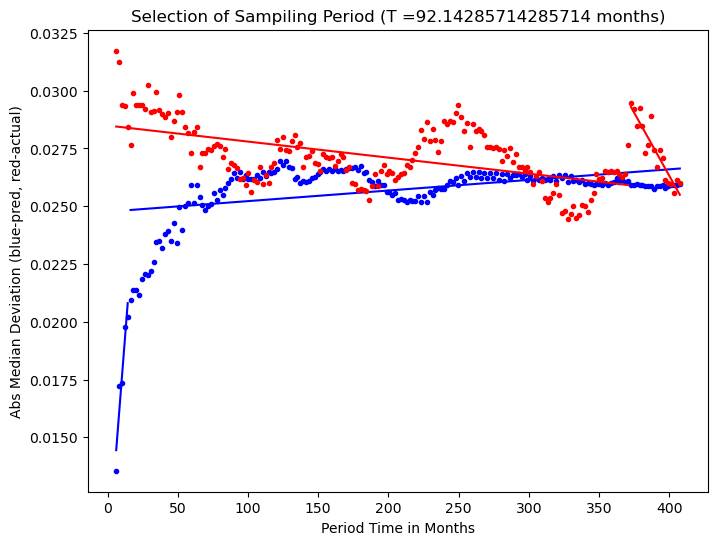

In [58]:

def calcRunningDev(x,periodMin,periodMax,predHor):
    
    
    n = len(x)
    devPred = np.array([])
    devAct = np.array([])
    periods = np.array([])
    
    for period in range(periodMin,periodMax,1):
        
        devPred_current = []
        devAct_current = []
        for j in range(period,n-predHor,1):
            temp = x[j-period:j]
            med = np.median(temp)
            devPred_current.append(np.median(np.abs(temp-med)))
            devAct_current.append(np.abs(med-x[j+predHor]))
            

        devPred = np.append(devPred,np.median(devPred_current))
        devAct = np.append(devAct,np.median(devAct_current))
        periods = np.append(periods,period)
        
    return devPred, devAct, periods

def trendConv(x1, x2, period=12, pCutoff = .1):
    """Here we determine if and when two trends
    converge in the sense that over a given period 
    they are not statistically different.
    the wilcoxon signed-rank test is used 
    to make this determination.
    We note that lack of rejecting the null hypothisis 
    is not equivlant to accepting the null, 
    but given that the stats are compared over tests on 
    sample data that represents the same variable 
    and the same number of observations, 
    we aregue that it is at least reasnable to determine 
    when value are relativly similar.
    """
    # if no convergance is found set defulat returns
    p = 1
    time = 0
    
    n = len(x1) # x1 and x2 must be same length
    
    inds = np.arange(0,period-1,1) # first set of values to test

    for i in range(0,n-period,period):
        wstat = wilcoxon(x1[inds+i],x2[inds+i])
        p = wstat.pvalue
        time = i + .5*period 
        if  p > pCutoff: break

    return time, p


def doubleLinearFunc(x,y):
    rsqBest = 0
    indBest = 0
    criteriaBest = 0
    yHat1Best = []
    yHat2Best = []
    x1Best = []
    x2Best = []
    n = len(y)
    for i in range(3,n-3,1):
        x1 = x[:i]
        y1 = y[:i]
        x2 = x[i:]
        y2 = y[i:]
        # Create X matrix
        X1 = add_constant(x1.reshape(-1, 1))
        ic1, rsqAdj1, yHat1, model1 = run_model(X1,y1)
        X2 = add_constant(x2.reshape(-1, 1))
        ic2, rsqAdj2, yHat2, model2 = run_model(X2,y2)
        rsq = (rsqAdj1 + rsqAdj2)/2
        criteria = rsq * (1 - 0.0*(i/n))
        if criteria > criteriaBest:
            criteriaBest = criteria
            rsqBest = rsq
            indBest = i
            yHat1Best = yHat1
            yHat2Best = yHat2
            x1Best = x1
            x2Best = x2
    return x1Best, yHat1Best, x2Best, yHat2Best, rsqBest, x[indBest]
            
        

### currently depricated
def expDecayHackFun(x,y):
    """So we eventually want to do something like 
    an exponental decay, but not exactly.
    For starters, it is not going to asymptotically
    approch zero.
    We could use a logistic function or other 
    types of functions, but to make things 
    quick for now we are going to hack a simplification.
    We will do a cordinate manipulation to 
    force it into an possible exp decay.
    We will use the back half to estimate
    a non zero asymptope.
    The cordinate shit that to zero.
    Then miror flip over the new x-axis if needed.
    The do a standard preprocessing on the observables
    so we can use OLS.  The parameters will still give us 
    the proper half life. 
    The stats will be a bit messy so we will keep an 
    eye out for warning signs.
    """
    # Last 1/3 to estimate asymtope
    n = len(x)
    ind = int(n*.66)
    yBack = y[ind:]
    # asymtope is average?
    ays = np.mean(yBack)
    cv = np.std(yBack) / ays
    print('CV = '+str(cv))
    if cv > 0.2:
        print('Warning: CV is too high, results may be poor')
    # shift down
    yShift = y - ays
    # check for and flip if needed
    flip=False
    if yShift[0] < 0:
        flip=True
        yShift = -1*yShift
    # exp function fit
    ### Run for exp function: y=Aexp(Bx) -> log(y)=log(A)+Bx
    name = 'Exp Function'

    X = add_constant(x.reshape(-1, 1))
    
    ic, rsqAdj, yHatShiftLog, model = run_model(X,np.log(yShift+1))
    # rescal yHat
    yHatShift = np.exp(yHatShiftLog)-1
    if flip:
        yHatShift = -1*yHatShift
    yHat = yHatShift + ays

    return rsqAdj, yHat, model

# data
y = sp500_history['Adj Close**'].to_numpy()

# monthly returns
nothing, returns = calcReturns(y, period= dinm)

# sampe freq
inds = np.arange(0,len(returns),delta_sf)
returns = returns[inds]
step2month = 43.0/21.0 


# get price changes
devPred, devAct, periods = calcRunningDev(returns,3,200,6)

# correction factor for step to months
periods = periods*step2month

# first look for convergance
time,p = trendConv(devPred, devAct, period = 6, pCutoff=.1)

# correction factor for time to months
time = time*step2month

print('Test for Convergance')
if time > 1:
    print('- Did Converge')
else:
    print('- Did NOT Converge')

print('- time = '+str(time))
print('- p = '+str(p))
    

# fit to modified decay function
#rsqAdjPred, yHatPred, modelPred = expDecayHackFun(periods,devPred)
#rsqAdjAct, yHatAct, modelAct = expDecayHackFun(periods,devAct)

x1Pred, yHat1Pred, x2Pred, yHat2Pred, rsqPred, cutoffPred = doubleLinearFunc(periods,devPred)
x1Act, yHat1Act, x2Act, yHat2Act, rsqAct, cutoffAct = doubleLinearFunc(periods,devAct)

print('')
print('Test for Break')
print('- Pred')
print('-- rsq = '+str(rsqPred))
print('-- time = '+str(cutoffPred))
print('- Act')
print('-- rsq = '+str(rsqAct))
print('-- time = '+str(cutoffAct))

if time > 1:
    T = time 
else:
    T = np.max([cutoffAct,cutoffPred])


plt.figure(figsize=(8, 6))
plt.plot(periods,devPred,'.',color='blue')
plt.plot(x1Pred,yHat1Pred,color='blue')
plt.plot(x2Pred,yHat2Pred,color='blue')
plt.plot(periods,devAct,'.',color='red')
plt.plot(x1Act,yHat1Act,color='red')
plt.plot(x2Act,yHat2Act,color='red')
plt.xlabel('Period Time in Months')
plt.ylabel('Abs Median Deviation (blue-pred, red-actual)')
plt.title('Selection of Sampiling Period (T ='+str(T)+' months)')
plt.show()



## IV Application for Managment  
Can we use the sampling rate here for portfolio analysis in general?
Does Event Length (EL) help us determine a sampling period for portfolio analysis in general?
Does EL help us determine a hold or portfolio re-balancing strategy?

### i. Some Messy Stuff

### ii. Some Interesting Stuff

### iii. Some Crtical Stuff to Move Project forward
* Defining a month as 21 consecutive time points in stock closing data as markets are closed on weekends and holidays.
* Suggesting a rebalancing every month given monthly investment deposits (using buy only strategy to avoid transaction friction calculations)
* Suggesting a reallocation (reoptimization) every 6 months (129 consecutive time points) and no earlier as this is the time of a typical (median) abnormal deviation event (which is abnormal but still to be expected at nearly 1/3 of all deviations).  
* Setting sampiling frequency as 43 or more days as ACF values drop to zeros, *resonably*, and hold based on criterion above.
* Setting sampiling period to 1932 days (92 months or ~7.7 years) as it takes this amount of time to switch from a steep to flat slope in the estimate between actual and predicted returns over 6 months (our suggested reallocation freq).

## X. Next Steps